# Lab:  Nonlinear Least Squares for Modeling Materials

Nonlinear least squares (NLLS) is a widely-used method for modeling data.  In NLLS, we wish to fit a model of the form,

     yhat = g(x,w)
     
where `w` is a vector of paramters and `x` is the vector of predictors.  We find `w` by minimizing a least-squares function 

     f(w) = \sum_i (y_i - g(x_i,w))^2
     
where the summation is over training samples `(x_i,y_i)`.  This is similar to linear least-squares, but the function `g(x,w)` may not be linear in `w`.  In general, this optimization has no closed-form expression.  So numerical optimization must be used.  

In this lab, we will implement gradient descent on NLLS in a problem of physical modeling of materials.  Specifically, we will estimate parameters for expansion of copper as a function of temperature using a real dataset.  In doing this lab, you will learn to:
* Set up a nonlinear least squares as an unconstrained optimization function
* Compute initial parameter estimates for a simple rational model
* Compute the gradients of the least squares objective
* Implement gradient descent for minimizing the objective
* Implement momentum gradient descent
* Visualize the convergence of the algorithm

We first import some key packages.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, LinearRegression

## Load the Data

The NIST agency has an excellent [nonlinear regression website](https://www.itl.nist.gov/div898/strd/nls/nls_main.shtml) that has several datasets for nonlinear regression problems.  In this lab, we will use the data from a NIST study involving the thermal expansion of copper. The response variable is the coefficient of thermal expansion, and the predictor variable is temperature in degrees kelvin.  

> Hahn, T., NIST (1979), Copper Thermal Expansion Study.  (unpublished}

You can download the data as follows.

In [ ]:
url = 'https://itl.nist.gov/div898/strd/nls/data/LINKS/DATA/Hahn1.dat'
df = pd.read_csv(url, skiprows=60, sep=' ',skipinitialspace=True, names=['y0','x0','dummy'])
df.head()

,y0,x0,dummy
0,0.591,24.41,NaN
1,1.547,34.82,NaN
2,2.902,44.09,NaN
3,2.894,45.07,NaN
4,4.703,54.98,NaN


Extract the `x0` and `y0` into arrays.  Rescale, `x0` and `y0` to values between `0` and `1` by dividing `x0` and `y0` by the maximum value.  Store the scaled values in vectors `x` and `y`.  The rescaling will help with the conditioning of the fitting.  Plot, `y` vs. `x`. 

Text(0.5, 1.0, 'y vs x')

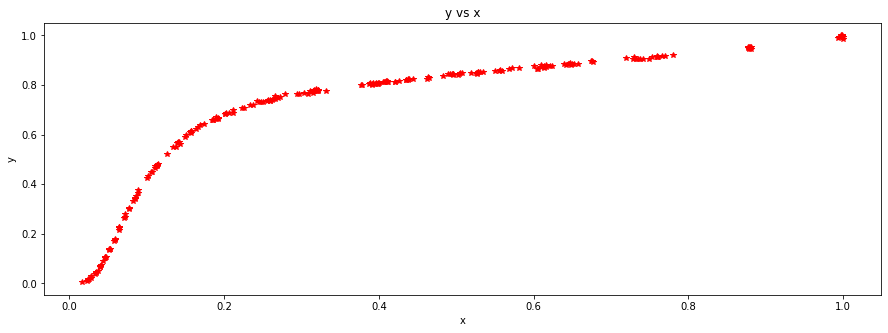

In [ ]:
x0 = df['x0']
y0 = df['y0']
x = x0/np.max(x0)
y = y0/np.max(y0)
args = np.argsort(x)
x = x[args]
y = y[args]
x = np.asarray(x)
y = np.asarray(y)
plt.figure(figsize=(15,5))
plt.plot(x,y,'*r')
plt.xlabel('x')
plt.ylabel('y')
plt.title('y vs x')

Text(0, 0.5, 'yn')

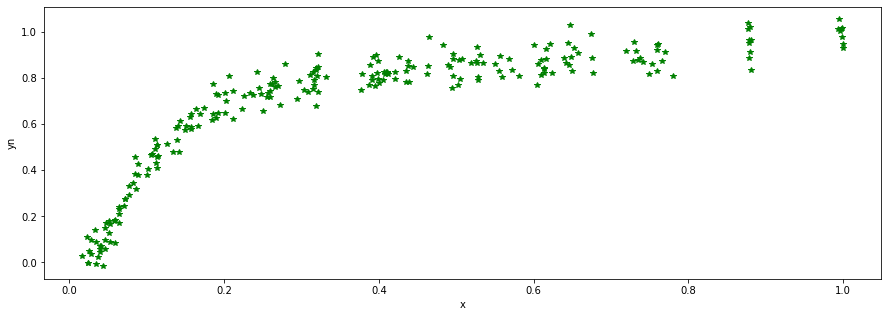

In [ ]:
# TODO
mu, sigma = 0, 0.05 
yn = y + np.random.normal(mu,sigma,size=y.shape)
plt.figure(figsize=(15,5))
plt.plot(x,yn,'*g')
plt.xlabel('x')
plt.ylabel('yn')

To make the problem a little more challenging, we will add some noise.  Add random Gaussian noise with mean 0 and std. dev = 0.02 to `y`.  Store the noisy results in `yn`. You can use the `np.random.normal()` function to add Gaussian noise. Plot `yn` vs. `x`.

Split the data `(x,yn)` into training and test.  Let `xtr,ytr` be training data and `xts,yts` be the test data.  You can use the `train_test_split` function.  Set `test_size=0.33` so that 1/3 of the samples are held out for test.

In [ ]:
from sklearn.model_selection import train_test_split
xtr, xts, ytr, yts = train_test_split(x, yn,test_size= 0.33,shuffle= True)

## Initial Fit for a Rational Model

The [NIST website](https://www.itl.nist.gov/div898/strd/nls/data/hahn1.shtml) suggests using a *rational* model of the form,

      yhat = (a[0] + a[1]*x + ... + a[d]*x^d)/(1 + b[0]*x + ... + b[d-1]*x^d)
      
with `d=3`.  The model parameters are `w = [a[0],...,a[d],b[0],...,b[d-1]]` so there are `2d+1` parameters total.    Complete the function below that takes vectors `w` and `x` and predicts a set of values `yhat` using the above model.
   

In [ ]:
def predict(w,x):
  d = (len(w)-1)//2
  a = w[0: d+1]
  b = w[d+1:]
  a=np.flip(a)
  b = np.concatenate(([1],b))
  b=np.flip(b)
  yhat_a = np.polyval(a,x)
  yhat_b= np.polyval(b,x)
  yhat=yhat_a/yhat_b
  return yhat

When we fit with a nonlinear model, most methods only get convergence to a local minima.  So, you need a good initial condition.  For a rational model, one way to get is to realize that if:


    y ~= (a[0] + a[1]*x + ... + a[d]*x^d)/(1 + b[0]*x + ... + b[d-1]*x^d)
    
Then:

    y ~= a[0] + a[1]*x + ... + a[d]*x^d - b[0]*x*y + ... - b[d-1]*x^d*y.
    
So, we can solve for the the parameters `w = [a,b]` from linear regression of the predictors,

    Z[i,:] = [ x[i], ... , x[i]**d, y[i]*x[i], ... , y[i}*x[i]**d ] 

In [ ]:
d=3
dp=np.arange(1,d+1)
print(dp)
Z = np.zeros((len(xtr),2*d))
for i in range(len(xtr)):
  k= np.power(xtr[i],dp)
  l= ytr[i]*np.power(xtr[i],dp)
  Z[i,:] = np.concatenate((k,l))
model = LinearRegression()
model.fit(Z,ytr)
# TODO
a = np.concatenate(([model.intercept_],model.coef_[0:d]))
b = -model.coef_[d:]
winit = np.concatenate((a,b))

[1 2 3]


Now plot the predicted values of the `yhat` vs. `x` using your estimated parameter `winit` for 1000 values `x` in `[0,1]`.  On the same plot, plot `yts` vs. `xts`.  You will see that you get a horrible fit.

(-0.2, 1.0)

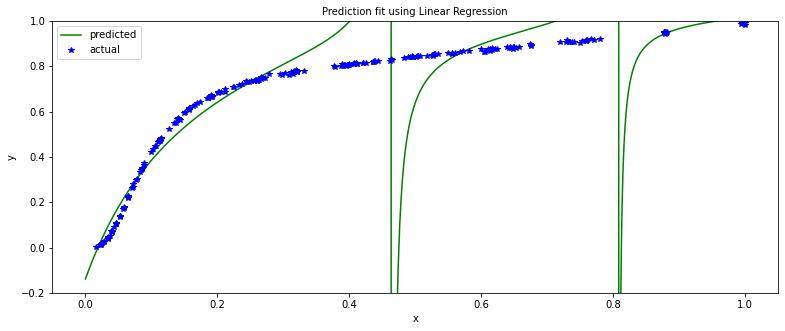

In [ ]:
# TODO
xp = np.linspace(0,1,num=1000)
yhat = np.zeros(len(xp))
for i in range(len(xp)):
  yhat[i] = predict(winit,xp[i])
i = np.argsort(xts)
xts, yts = xts[i], yts[i]
plt.figure(figsize=(13,5))
plt.plot(xp,yhat,'g')
plt.plot(x,y,'*b')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(('predicted','actual'),fontsize=10)
plt.title('Prediction fit using Linear Regression',fontsize=10)
plt.grid()
(-0.2, 1.0)
plt.grid()
plt.ylim([-0.2,1])

The reason the previous fit is poor is that the denominator in `yhat` goes close to zero.   To avoid this problem, we can use Ridge regression, to try to keep the parameters close to zero.  Re-run the fit above with `Ridge` with `alpha = 1e-3`. You should see you get a reasonable, but not perfect fit.

(-0.2, 1.0)

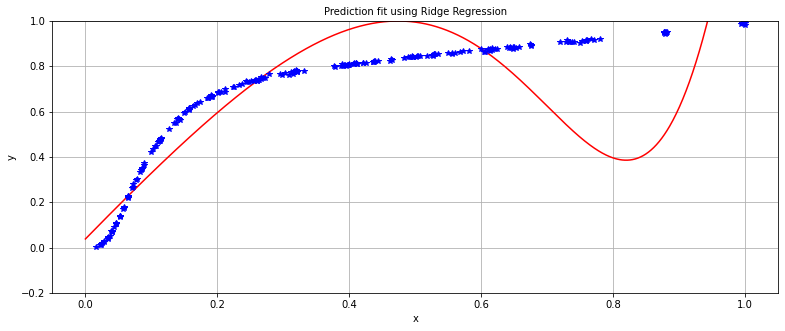

In [ ]:
# TODO.  Fit with parameters with linear regression
reg = Ridge(alpha=1e-3)
reg.fit(Z,ytr)
a = np.concatenate(([reg.intercept_],reg.coef_[0:d]))
b = -reg.coef_[d:]
winit = np.concatenate((a,b))
xp = np.linspace(0,1,num=1000)
yhat = np.zeros(len(xp))
yhat[:] = predict(winit,xp[:])
plt.figure(figsize=(13,5))
plt.plot(xp,yhat,'r')
plt.plot(x,y,'*b')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Prediction fit using Ridge Regression',fontsize=10)
plt.grid()
plt.ylim([-0.2,1])

## Creating a Loss Function

We can now use gradient descent to improve our initial estimate.  Complete the following function to compute

    f(w) = 0.5*\sum_i (y[i] - yhat[i])^2
    
and `fgrad`, the gradient of `f(w)`.

In [ ]:
def feval(w,x,y):
  d = (len(w)-1)//2
  a = w[0:d+1]
  b = w[d+1:]
# TODO. Znum[i,j] = x[i]**j
  Znum = np.zeros((len(x),d+1))
  for i in range(len(x)):
    for j in range(d+1):
      Znum[i,j] = x[i]**j
# TODO. Zden[i,j] = x[i]**(j+1)
  Zden = np.zeros((len(x),d))
  for i in range(len(x)):
    for j in range(d):
      Zden[i,j] = x[i]**(j+1)
  yhat = np.zeros(len(x))
  for i in range(len(x)):
    yhat[i] = Znum[i,:].dot(a)/(1+Zden[i,:].dot(b))
  f = 0.5*np.sum(np.square(y-yhat))
  grada = np.zeros(len(a))
  for j in range(len(a)):
    grada[j] = -np.sum((y-yhat)*Znum[:,j]/(1+np.matmul(Zden,b)))
  gradb = np.zeros(len(b))
  for j in range(len(b)):
    gradb[j] = np.sum((y-yhat)*yhat*Zden[:,j]/(1+np.matmul(Zden,b)))
  fgrad = np.concatenate((grada,gradb))
  return f, fgrad


Test the gradient function:
* Take `w0=winit` and compute `f0,fgrad0 = feval(w0,xtr,ytr)`
* Take `w1` very close to `w0` and compute `f1,fgrad1 = feval(w1,xtr,ytr)`
* Verify that `f1-f0` is close to the predicted value based on the gradient.

In [ ]:
# TODO
w0 = winit
f0, fgrad0 = feval(w0,xtr,ytr)
w1 = w0 + 1e-6
f1,fgrad1 = feval(w1,xtr,ytr)
print('Actual Difference: %.4f'%(f1-f0))
print('Predicted Difference using gradient: %.4f'%(fgrad0.dot(w1-w0)))

Actual Difference: -0.0002
Predicted Difference using gradient: -0.0002


## Implement gradient descent

We will now try to minimize the loss function with gradient descent.  Using the function `feval` defined above, implement gradient descent.  Run gradient descent with a step size of `alpha=1e-6` starting at `w=winit`.  Run it for `nit=10000` iterations.  Compute `fgd[it]`= the objective function on iteration `it`.  Plot `fgd[it]` vs. `it`.  

You should see that the training loss decreases, but it still hasn't converged after 10000 iterations.

(-3.0, 100.0)

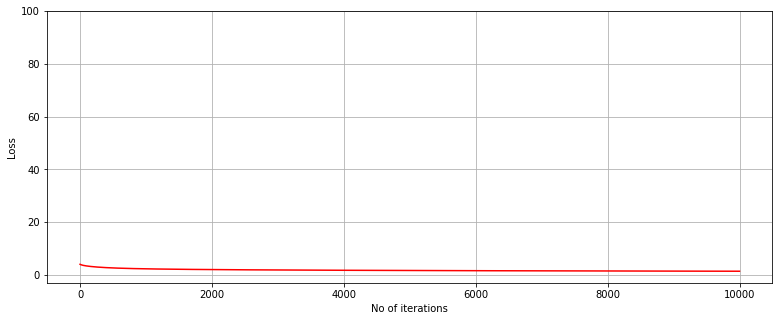

In [ ]:
# TODO
# TODO
# fgd = ...
nit = 10000
step = 1e-6
# Create history dictionary for tracking progress per iteration.
# This isn't necessary if you just want the final answer, but it
# is useful for debugging
hist = {'w': [], 'f': []}
for i in range(nit):
  f0,fgrad0 = feval(w0,xtr,ytr)
  w0 = w0 - fgrad0*step
  hist['w'].append(w0)
  hist['f'].append(f0)
for elem in ('f', 'w'):
  hist[elem] = np.array(hist[elem])
t = np.arange(nit)
loss = np.array(hist['f'])
plt.figure(figsize=(13,5))
plt.plot(t,loss,'r-')
plt.xlabel('No of iterations')
plt.ylabel('Loss')
plt.grid()
plt.ylim(-3,100)

Now, try to get a faster convergence with adaptive step-size using the Armijo rule. Implement the gradient descent with adaptive step size.  Let `fadapt[it]` be the loss function on iteration `it`.  Plot `fadapt[it]` and `fgd[it]` vs. `it` on the same graph.  You should see a slight improvement, but not much.

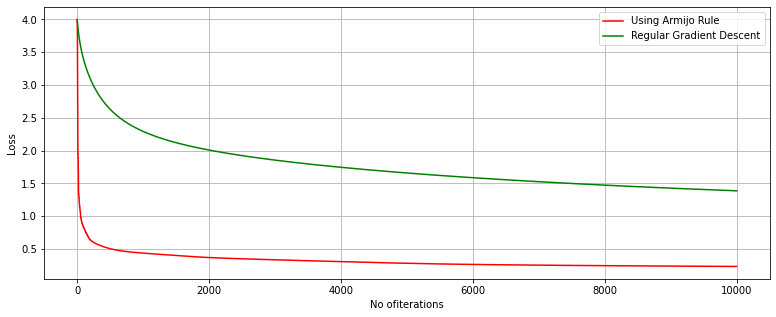

In [ ]:
# TODO
# fadapt = ...
nit = 10000
step = 1e-6 # Initial step
hist = {'w':[],'f':[]}
w0 = winit; f0, fgrad0 = feval(winit,xtr,ytr)
for i in range(nit):
  w1 = w0 - fgrad0*step
  f1, fgrad1 = feval(w1,xtr,ytr)
  df = fgrad0.dot(w1-w0)
  al = 0.5
  if (f1-f0 < al*df) and (f1<f0):
    step = step*2
    f0 = f1
    fgrad0 = fgrad1
    w0 = w1
  else:
    step = step/2
  hist['w'].append(w0)
  hist['f'].append(f0)
loss_arm = np.array(hist['f'])
plt.figure(figsize=(13,5))
plt.plot(loss_arm,'r-')
plt.plot(loss,'g-')
plt.xlabel('No ofiterations')
plt.ylabel('Loss')
plt.grid()
plt.legend(('Using Armijo Rule','Regular Gradient Descent'))

Using he final estimate for `w` from the adaptive step-size plot the predicted values of the `yhat` vs. `x` usfor 1000 values `x` in `[0,1]`.  On the same plot, plot `yhat` vs. `x` for the initial parameter `w=winit`.  Also, plot `yts` vs. `xts`.  You should see that gradient descent was able to improve the estimat slightly, although the initial estimate was not too bad.

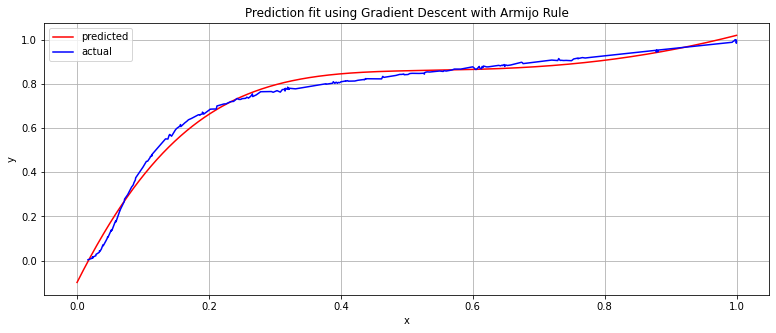

In [ ]:
# TODO
w2 = np.array(hist['w'])[10000-1,:]
xp = np.linspace(0,1,num=1000)
yhat = predict(w2,xp)
plt.figure(figsize=(13,5))
plt.plot(xp,yhat,'r')
plt.plot(x,y,'b')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(('predicted','actual'))
plt.title('Prediction fit using Gradient Descent with Armijo Rule')
plt.grid()

## Momentum Gradient Descent

This section is bonus.

One way to improve gradient descent is to use *momentum*.  In momentum gradient descent, the update rule is:

    f, fgrad = feval(w,...)
    z = beta*z + fgrad
    w = w - step*z
    
This is similar to gradient descent, except that there is a second order term on the gradient.  Implement this algorithm with `beta = 0.99` and `step=1e-3`.   Compare the convergence of the loss function with gradient descent.  

In [ ]:
# TODO
nit = 10000
step = 1e-5
beta = 0.99
z = np.zeros(np.shape(winit))
hist = {'w':[],'f':[]}
w3 = winit
for i in range(nit):
  f0, fgrad0 = feval(w3,xtr,ytr)
  z = z*beta + fgrad0
  w3 = w3 - z*step
  hist['w'].append(w3)
  hist['f'].append(f0)
loss_momentum = np.array(hist['f'])

(0.0, 100.0)

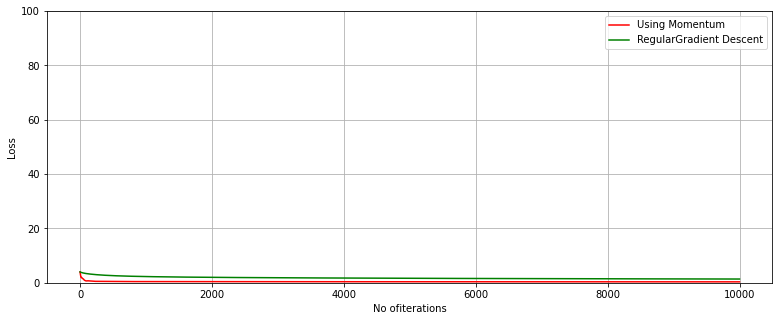

In [ ]:
# TODO
# plot yhat vs. x
plt.figure(figsize=(13,5))
plt.plot(loss_momentum,'r-')
plt.plot(loss,'g-')
plt.xlabel('No ofiterations')
plt.ylabel('Loss')
plt.grid()
plt.legend(('Using Momentum','RegularGradient Descent'))
plt.ylim([0,100])#

## Beyond This Lab
In this lab, we have just touched at some of the ideas in optimization.  There are several other important algorithms that you can explore:
* [Levenberg-Marquardt](https://en.wikipedia.org/wiki/Levenberg%E2%80%93Marquardt_algorithm) method for non-linear least squares
* Newton's method
* More difficult non-linear least squares problems.